In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyxdf
import re
import seaborn as sns

In [2]:
datasrc = "/net/store/nbp/projects/GTI_decoding/data/pilot"

triggers = ['CueTimeStamp',
                'CueDisappearedTimeStamp',
                'ObjectShownTimeStamp',
                'BeepPlayedTimeStamp',
                'ButtonPressedTimeStamp']
eeg = 'openvibeSignal'
stimulus = 'ToolCueOrientationString'

event_mapping = {'task': 1,
                 'inter-task-object': 2,
                 'object': 3,
                 'action': 4,
                 'inter-trial':5 }

conditions = ['lift/daisygrubber/left','lift/daisygrubber/right','lift/fishscaler/left'
 'lift/fishscaler/right','lift/flowercutter/left',
 'lift/flowercutter/right','lift/fork/left','lift/fork/right'
 'lift/paintbrush/left','lift/paintbrush/right','lift/paletteknife/left',
 'lift/paletteknife/right','lift/screwdriver/left',
 'lift/screwdriver/right','lift/spatula/left','lift/spatula/right',
 'lift/spokewrench/left','lift/spokewrench/right','lift/trowel/left',
 'lift/trowel/right','lift/wrench/left','lift/wrench/right',
 'lift/zester/left','lift/zester/right','use/daisygrubber/left',
 'use/daisygrubber/right','use/fishscaler/left','use/fishscaler/right',
 'use/flowercutter/left','use/flowercutter/right','use/fork/left',
 'use/fork/right','use/paintbrush/left','use/paintbrush/right',
 'use/paletteknife/left','use/paletteknife/right','use/screwdriver/left',
 'use/screwdriver/right','use/spatula/left','use/spatula/right',
 'use/spokewrench/left','use/spokewrench/right','use/trowel/left',
 'use/trowel/right','use/wrench/left','use/wrench/right','use/zester/left',
 'use/zester/right']

pilots = [f for f in os.listdir(datasrc) if re.match(r'P[\d]+', f)]

In [3]:
def get_streams(dxdf):
    trig_streams = [99] * len(triggers)
    eeg_stream = 99
    stim_stream = 99 
    
    for i in range(len(data)):
        if data[i]["info"]['name'][0] == eeg:
            eeg_stream = i
        elif data[i]["info"]['name'][0] == stimulus:
            stim_stream = i
        else:
            try:
                trig_streams[triggers.index(data[i]["info"]['name'][0])] = i
            except:
                pass
    return eeg_stream, stim_stream, trig_streams


def get_stimulus_from_header(dxdf,block,idx):
    tmplst = []
    for i in range(len(dxdf[idx]["time_series"])):
        tmp = {}
        tmp['block'] = block
        tmp['tool'] = dxdf[idx]["time_series"][i][0]
        tmp['cue'] = dxdf[idx]["time_series"][i][2]
        tmp['ori'] = dxdf[idx]["time_series"][i][3]
        tmplst.append(tmp)
    return tmplst
        
def get_event_triggers(dxdf,block,eeg_stream,trig_streams,event_map): # Extract the triggers and concatenate them
    tmpdfs = []
    evntlist = {desc:idx for idx, desc in event_map.items()}
    for i, stim_idx in enumerate(trig_streams):
        tmpdf = pd.DataFrame(data[stim_idx]["time_stamps"],columns=[evntlist[i + 1]])
        tmpdfs.append(tmpdf)
    
    tmpdf = pd.concat(tmpdfs,axis=1)
    tmpdf['block'] = block
    tmpdf = tmpdf.reset_index().rename(columns={'index':'trial_id'})
    
    return tmpdf


def extract_stimulus(tmpdf):
    tmpdf['cond'] = tmpdf.apply(lambda x: "/".join([x['cue'],x['tool'],x['ori']]),axis=1)
    tmpdf['eq'] = tmpdf['cond'] == tmpdf['cond'].shift()
    tmpdf = tmpdf.loc[~df['eq'],:].reset_index(drop=True)
    tmpdf.drop(columns=['eq'],axis=1,inplace=True)
    tmpdf = tmpdf.reset_index().rename(columns={'index':'trial_id'})
    return tmpdf
    

In [4]:
def inspect_events(evt_arr,event_map,sfreq):
    #inspect the consistency of the triggers
    evntlist = {desc:idx for idx, desc in event_map.items()}
    df=pd.DataFrame({'sample_idx':evt_arr[:,0], 'dummy':evt_arr[:,1],'event_id':evt_arr[:,2]})
    df['event_id'].replace(evntlist,inplace=True)
    df['dur'] = df['sample_id'].diff(-1)*-1/sfreq
    #df = df[pd.notna(df['dur'])]
    print(df)
    return

In [5]:
def gather_one_subject_data(trial_df,event_df):
    x = event_df.reset_index().drop(columns=['index','trial_id'],axis=1).reset_index().rename(columns={'index':'trial_id'})
    y = trial_df.merge(x,on=['trial_id','block'])
    task_t = y['inter-task-object'] - y['task']
    inter_task_object_t = y['object'] - y['inter-task-object']
    object_t = y['action'] - y['object']
    action_t = y['inter-trial'] - y['action']
    inter_trial_t = y['task'].shift(-1) - y['inter-trial']
    y['task'] = task_t
    y['inter-task-object'] = inter_task_object_t
    y['object'] = object_t
    y['action'] = action_t
    y['inter-trial'] = inter_trial_t
    block_change = y['block'] != y['block'].shift(-1)
    y.loc[block_change,'inter-trial'] = np.NaN
    
    return y
    

In [6]:
def check_block_data(f,block,eeg_stream, stim_stream, trig_streams):
    if (eeg_stream == 99) |  (stim_stream == 99) | (99 in trig_streams):
        print(" Subject id: {}, Block id: {}. All data not found. Skipped".format(f,block))
        print(eeg_stream,stim_stream, trig_streams )
        return False
    else:
        return True

In [7]:
testdata = []
for f in pilots:
    datafiles = glob.glob(os.path.join(datasrc,f,"*.xdf"))
    datalist = []
    eventlist = []
    d = 0
    for fl in datafiles:
        block = int(fl.split("_")[-1].rstrip(".xdf"))
        data, header = pyxdf.load_xdf(fl)
        eeg_stream, stim_stream, trig_streams = get_streams(data)
        if check_block_data(f,block,eeg_stream, stim_stream, trig_streams):
            datalist.extend(get_stimulus_from_header(data,block,stim_stream))
            eventlist.append(get_event_triggers(data,block,eeg_stream,trig_streams,event_mapping))
    
    df = pd.DataFrame(datalist,columns=['block','tool','cue','ori'])
    df['subj_id'] = f
    df = extract_stimulus(df)
    edf = pd.concat(eventlist)
    testdata.append(gather_one_subject_data(df,edf))
    


 Subject id: P004, Block id: 1. All data not found. Skipped
1 99 [99, 99, 99, 99, 99]


In [8]:
subj_df = pd.concat(testdata)

In [9]:
subj_df

,trial_id,block,tool,cue,ori,subj_id,cond,task,inter-task-object,object,action,inter-trial
0,0,1,flowercutter,use,right,P001,use/flowercutter/right,2.005518,0.512057,3.007945,4.242989,1.018492
1,1,1,screwdriver,lift,right,P001,lift/screwdriver/right,2.012002,0.512393,3.008735,5.676056,1.019285
2,2,1,paletteknife,use,left,P001,use/paletteknife/left,2.013716,0.511481,3.007724,5.709325,1.018833
3,3,1,flowercutter,use,left,P001,use/flowercutter/left,2.012894,0.510555,3.009587,7.063972,1.018229
4,4,1,wrench,use,left,P001,use/wrench/left,2.013749,0.512550,3.008674,10.738863,1.019229
...,...,...,...,...,...,...,...,...,...,...,...,...
235,235,6,fork,use,left,P004,use/fork/left,2.012794,0.512276,3.007810,4.010530,1.018175
236,236,6,spatula,use,right,P004,use/spatula/right,2.013285,0.511219,3.008695,6.020505,1.018894
237,237,6,zester,use,right,P004,use/zester/right,2.012631,0.512131,3.007892,4.077287,1.018581
238,238,6,zester,use,left,P004,use/zester/left,2.008252,0.516023,3.009101,4.498148,1.018961


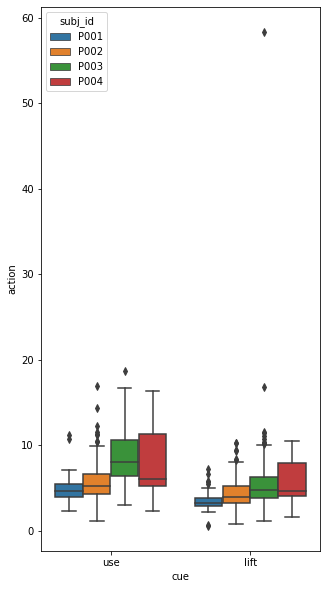

In [10]:
#inspect the consistency of the triggers
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(data=subj_df[pd.notna(subj_df)],y='action',x='cue',hue='subj_id',ax=ax)
plt.show()


# eeg preprocessing steps

    1. Load the block
    2. Gather the summary of the EEG channels
    3. Gather summary of the triggers
    4. Create the event array in mne format
    5. Load EEG into mne

